<a href="https://colab.research.google.com/github/aekomissarova/dog_breed_classification/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of dog breeds - https://www.kaggle.com/c/dog-breed-identification/overview 

In [17]:
!unzip "/content/drive/MyDrive/dog_breed_classification/dog-breed-identification.zip" -d "/content/drive/MyDrive/dog_breed_classification"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: /content/drive/MyDrive/dog_breed_classification/train/83fad0718581a696132c96c166472627.j

In [18]:
# Import tensorFlow
import tensorflow as tf
print("TF version", tf.__version__)

TF version 2.9.2


In [19]:
#Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

TF Hub version: 0.12.0


In [20]:
#Check for GPU availability
print("GPU:","available" if tf.config.list_physical_devices("GPU") else "not available")

GPU: available


In [21]:
#Prepare data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

labels = pd.read_csv("/content/drive/MyDrive/dog_breed_classification/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


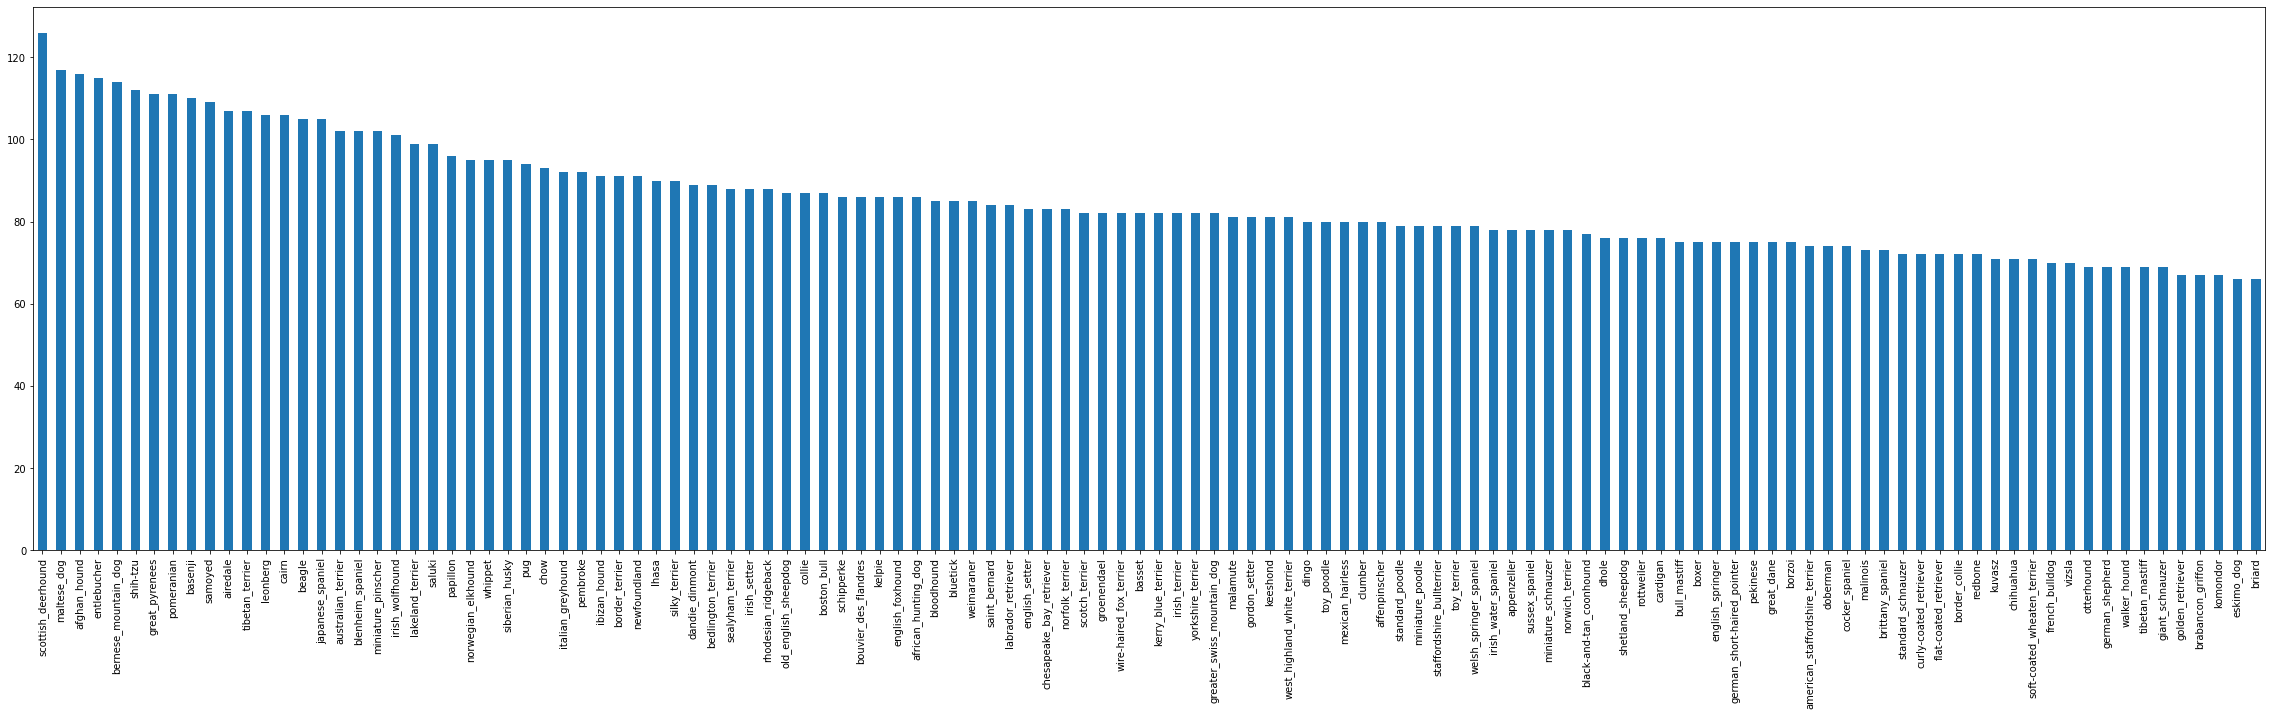

In [22]:
#How many pictures do we have for each breed?
labels["breed"].value_counts().plot.bar(figsize = (40,10))

In [23]:
labels["breed"].value_counts().median()

82.0

In [24]:
labels["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

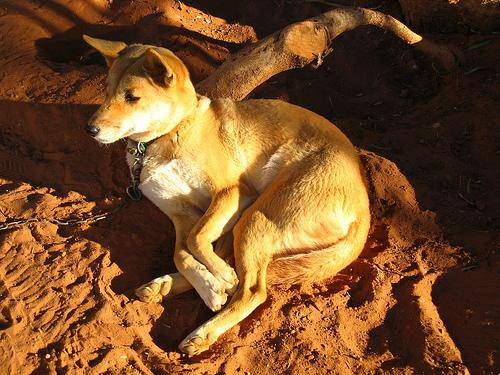

In [25]:
#View an image
from IPython.display import Image
Image(data = "/content/drive/MyDrive/dog_breed_classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

In [35]:
#Get a list of all images pathnames
train_directory = "drive/MyDrive/dog_breed_classification/train/"


filenames = [train_directory + fname + ".jpg" for fname in labels["id"]]
filenames[:5]


['drive/MyDrive/dog_breed_classification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/dog_breed_classification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/dog_breed_classification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/dog_breed_classification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/dog_breed_classification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [36]:
# Verify our results for filenames

import os
if len([os.path.join(train_directory,file) for file in os.listdir(train_directory)]) == len(filenames):
  print("Filenames are correct")
else:
  print("Filenames are not correct")

Filenames are correct


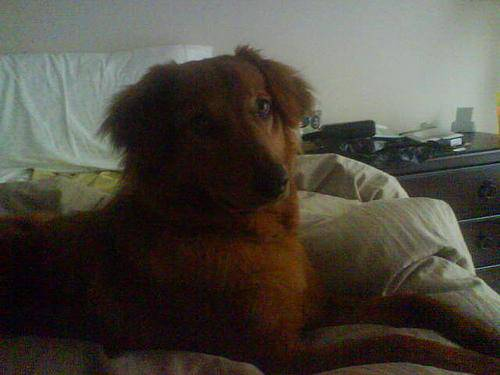

In [37]:
Image(data = filenames[1000])

In [49]:
unique_breeds = np.unique(labels)

boolean_labels = [label == np.array(unique_breeds) for label in labels]
X = filenames
y = boolean_labels[0]
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}


In [50]:
#boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [51]:
# Import train_test_split from Scikit-Learn
from sklearn.model_selection import train_test_split

# Split them into training and validation using NUM_IMAGES 
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [56]:
# Define image size
IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image